In [1]:
import nbsetup
import pymc3 as pm
import numpy as np
import scipy as sp
import seaborn as sns
import pandas as pd
import arviz as az
from matplotlib import pyplot as plt

In [2]:
from models.sparc.dataframe import load_analysis

In [3]:
df = load_analysis()

In [13]:
coords = {
    "galaxy": df.ID.unique(),
    "observation": df.Vobs.index
}

gamma_mu = 6
alpha_mu = 0.15


with pm.Model(coords=coords) as galaxy_model:
    
    # Universal priors
    gamma = pm.Uniform('gamma', 0, 20)
    alpha = pm.Uniform('alpha', 0, 2)
    sigma = pm.HalfCauchy("sigma", beta=5, dims="galaxy") # observational error

    # Data
    force = pm.Data("force", df.Fnewton, dims="observation")
    radius = pm.Data("radius", df.R, dims="observation")
    nulled = pm.Data("nulled", df.Fnulled, dims="observation")
    #g = pm.Data("g", df.gidx, dims="observation")
    
    # Prediction model
    ftd = force*(gamma/(1+(nulled)**alpha)) # adjust for nulled field
    vtd = np.sqrt(ftd*radius)#*dist[g]/D_FROMSPARC) # adjust r for distance when calc V
    #vinc = vtd*np.sin(inc[g]*np.pi/180)/np.sin(INC_FROMSPARC*np.pi/180) # adjust for inclination of Vobs
    Vpred = pm.Deterministic("prediction", vtd, dims="observation")
    
    # Define likelihood
    obs = pm.Lognormal("obs", mu=Vpred, sigma=sigma[g], observed=df.Vobs, dims="observation")

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha, gamma]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 21 seconds.
There were 495 divergences after tuning. Increase `target_accept` or reparameterize.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.370906991939323, but should be close to 0.5. Try to increase the number of tuning steps.
There were 497 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.343276425607045, but should be close to 0.5. Try to increase the number of tuning steps.
There were 496 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.34515960510399785, but should be close to 0.5. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is

KeyboardInterrupt: 

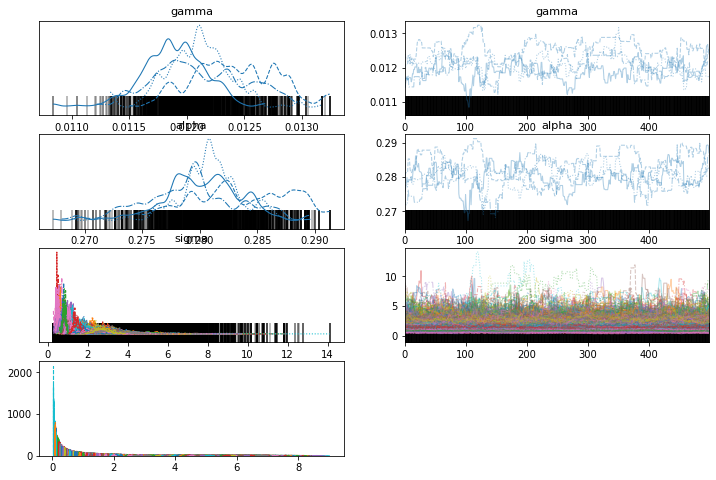

In [14]:
with galaxy_model:
    trace = pm.sample(tune=1000, draws=500, cores=4, return_inferencedata=True, target_accept=0.5)

az.plot_trace(trace);

In [ ]:
trace

In [ ]:
coords = {
    "galaxy": df.ID.unique(),
    "observation": df.Vobs.index
}

gamma_mu = 6
alpha_mu = 0.15

with pm.Model(coords=coords) as galaxy_model:
    
    # Universal priors
    gamma = pm.Normal('gamma', gamma_mu)
    alpha = pm.Normal('alpha', alpha_mu)
    
    # Galaxy priors
    DegreesNormal = pm.Bound(pm.Normal, lower=0.0, upper=90.0)
    inc = DegreesNormal('inclination', mu=FROMSPARC, sigma=FROMSPARC, dims='galaxy')
    PositiveNormal = pm.Bound(pm.Normal, lower=0.0)
    dist = pm.PositiveNormal('distance', mu=FROMSPARC, sigma=FROMSPARC, dims='galaxy')
    #tau = pm.Exponential('tau field', 1)
    sigma = pm.HalfCauchy("sigma", beta=FROMSPARC, dims="galaxy") # observational error

    # Data
    f = pm.Data("f", df.x_vec, dims="observation")
    r = pm.Data("r", df.R, dims="observation")
    nu = pm.Data("nu", df.nulled, dims="observation")
    g = pm.Data("g", df.gidx, dims="observation")
    
    # Prediction model
    ftd = f*(gamma/(1+(nu)**alpha)) # adjust for nulled field
    vtd = np.sqrt(ftd*r*dist[g]/D_FROMSPARC) # adjust r for distance when calc V
    vinc = vtd*np.sin(inc[g]*np.pi/180)/np.sin(INC_FROMSPARC*np.pi/180) # adjust for inclination of Vobs
    Vpred = pm.Deterministic("prediction", vinc, dims="observation")
    
    # Define likelihood
    obs = pm.Normal("obs", mu=Vpred, sigma=sigma[g], observed=df.Vobs, dims="observation")